# Gradients $\times$ Input

The gradients $\times$ input attribution method produces an image-specific attribution map which corresponds to the gradient of the output with respect to the input times the input, hence the name "gradients $\times$ input". This method is derived from the standard gradient method, shown in a seperate notebook. Its as simple as the gradient attribution method, but provides clearer results. It can be used with any classification model, since it only depends on the inputs gradients, not any gradients from the hidden layers and the input themselves.

For more technical information on the gradients $\times$ input attribution method see: [Learning Important Features Through Propagating Activation Differences](https://arxiv.org/abs/1704.02685)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import flax.linen as nn
import jax
from jax import random
from jax import grad
from keras.utils import data_utils

2022-11-21 10:21:30.255853: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 10:21:31.553196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-21 10:21:31.553629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-21 10:21:31.553641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned a

### Load training data
Check if the training data exists. If not, automatically download it.

In [2]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.zip"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.zip"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(
        train_data_path, 
        train_data_url, 
        extract=True, 
        cache_dir=data_dir
        )

data_df = pd.read_csv('./digit-recognizer/datasets/train.csv')

In [3]:
val_size = 1000
# Only shuffle training data
np.random.shuffle(data_df[val_size:].values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[val_size:]
X_train = X_train / 255.
Y_train = Y[val_size:]

X_val = X[:val_size]
X_val = X_val / 255.
Y_val = Y[:val_size]

### Define the classification model

In [4]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        mlp = nn.Sequential([
            nn.Dense(10), jax.nn.relu,
            nn.Dense(10), jax.nn.softmax        
        ])
        return mlp(x)

# Create the model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
initial_params = forward_fn.init(rng_key, dummy_x)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path         ┃ module      ┃ inputs         ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│              │ _forward_fn │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Sequential_0 │ Sequential  │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Dense_0      │ Dense       │ float32[5,784] │ float32[5,10] │ bias:          │
│              │             │                │               │ float32[10]    │
│              │             │                │               │ kernel:        │
│              │             │                │               │ float32[784,1… │
│              │           

### Define the loss function and update method

In [5]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[..., None] == jnp.arange(k), dtype)

def loss_fn(params, X, Y):
    logits = forward_fn.apply(params, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(logits)) / m
    return loss


def update_rule(params, update):
    return params - 0.1 * update

def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


### Train the model

In [6]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng, X)
    for i in range(iterations):
        params = update_params(params, alpha, X, Y)
        if i % 10 == 0:
            print("Iteration: ", i)
            logits = forward_fn.apply(params, X)
            predictions = get_predictions(logits)
            print(get_accuracy(predictions, Y))
    return params

In [7]:
params = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
0.103780486
Iteration:  10
0.36390242
Iteration:  20
0.4557073
Iteration:  30
0.52492684
Iteration:  40
0.5534634
Iteration:  50
0.59139025
Iteration:  60
0.6319024
Iteration:  70
0.66214633
Iteration:  80
0.68326825
Iteration:  90
0.7022927
Iteration:  100
0.71760976
Iteration:  110
0.73236585
Iteration:  120
0.74560976
Iteration:  130
0.7611951
Iteration:  140
0.77478045
Iteration:  150
0.7866829
Iteration:  160
0.795439
Iteration:  170
0.80202436
Iteration:  180
0.80826825
Iteration:  190
0.8137073
Iteration:  200
0.8189268
Iteration:  210
0.8227805
Iteration:  220
0.82707316
Iteration:  230
0.83131707
Iteration:  240
0.8345122
Iteration:  250
0.83763415
Iteration:  260
0.8410488
Iteration:  270
0.8441707
Iteration:  280
0.84682924
Iteration:  290
0.8494146
Iteration:  300
0.8514634
Iteration:  310
0.8536341
Iteration:  320
0.8555366
Iteration:  330
0.858
Iteration:  340
0.8599512
Iteration:  350
0.862317
Iteration:  360
0.86417073
Iteration:  370
0.86612195
Iteration:

### Display predictions and attribution maps

The jax "grad" function is used to extract the gradients used for the attribution map. The only gradients needed are the input gradients, hence agrnums=1. This is different to how grad is used for training, shown above. When training only the gradients for the models parameters are needed. Its also possible to extract the input gradients while training, which could be useful for debugging. As you can see below the only difference in the code to the standard gradients method is that the gradients are multiplied by the inputs before displaying the attribution map.

In [8]:
def make_predictions(X, params):
    logits = forward_fn.apply(params, X)
    predictions = get_predictions(logits)
    return predictions

def prep_image(image):
    # Normalize the gradient values to be between 0-1
    max_val= np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val)
    # Convert the grads to uint8 for displaying
    image = np.uint8(image * 255)
    return image  

def display_prediction(index, params):
    current_image = X_val[None, index]
    prediction = make_predictions(X_val[None, index], params)
    label = Y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Calculate the derivative WRT the input image
    grads = grad(loss_fn, argnums=1)(params, current_image, label)[0]
    # Multiply gradients by the input
    attributions = grads * current_image

    attributions = attributions.reshape((28, 28))
    attributions = prep_image(attributions)
    plt.gray()
    plt.imshow(attributions, interpolation='nearest')
    plt.axis('off')
    plt.title("Attribution Map")
    plt.show()

Prediction:  [1]
Label:  1


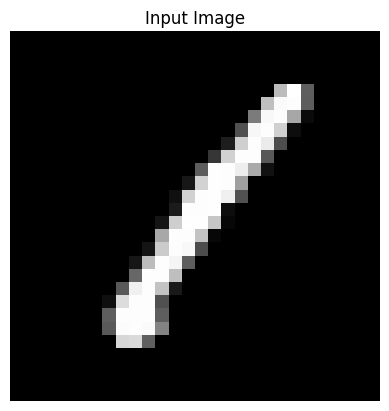

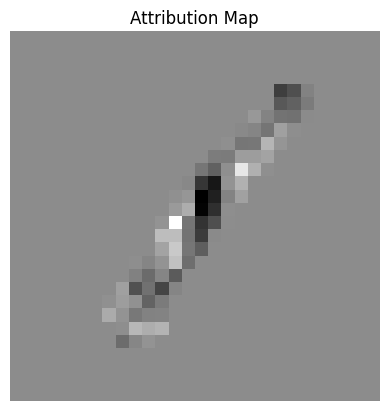

Prediction:  [6]
Label:  4


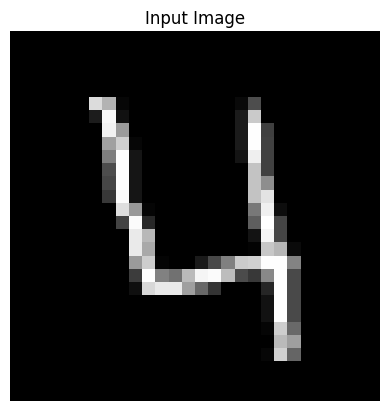

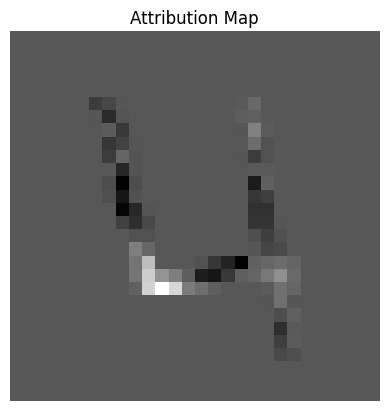

Prediction:  [3]
Label:  0


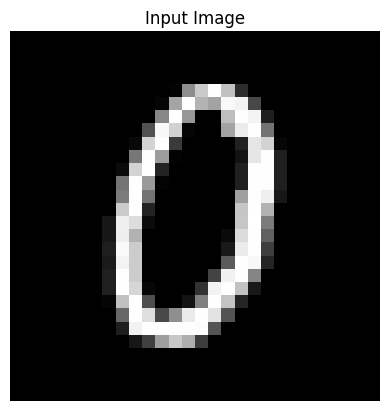

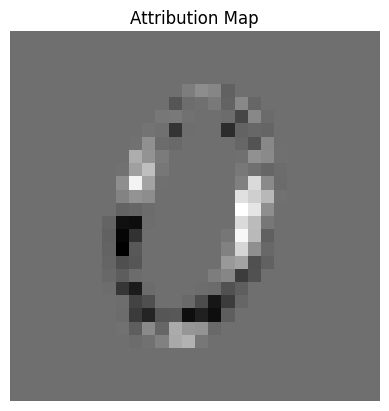

Prediction:  [5]
Label:  5


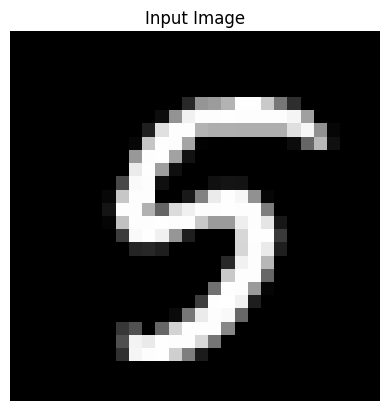

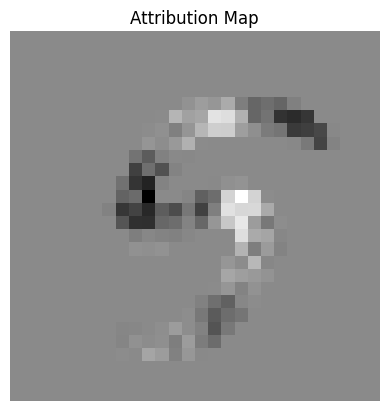

Prediction:  [8]
Label:  8


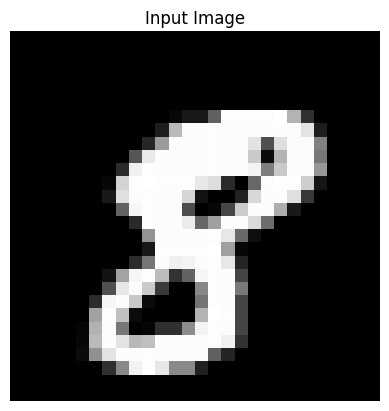

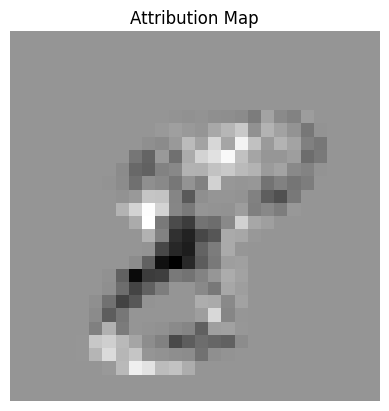

Prediction:  [7]
Label:  7


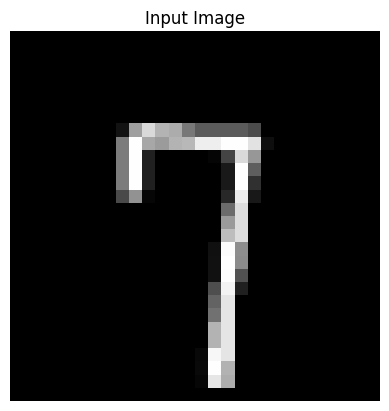

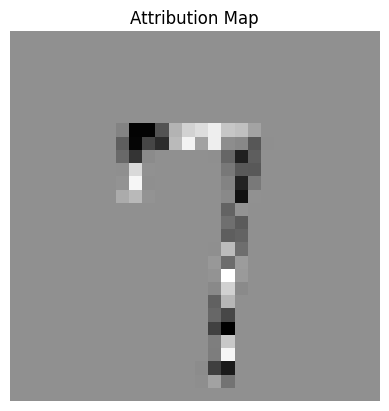

In [9]:
display_prediction(0, params)
display_prediction(3, params)
display_prediction(5, params)
display_prediction(8, params)
display_prediction(10, params)
display_prediction(50, params)